In [1145]:
import sqlite3 as sql
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1146]:
train_path = "Titanic/train.csv"
test_path = "Titanic/train.csv"
train_df = pd.read_csv(train_path)

In [1147]:
traindb = sql.connect("Titanic.db")
#Shuffles and split the data
train, val = train_test_split(train_df, test_size = 0.15)
train.to_sql("Train_DB",traindb)
val.to_sql("Val_DB",traindb)
traindb.close()

In [1148]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
601,602,0,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,NaN,S
387,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


In [1149]:
#We combine SibSp(siblings) and Parch(parent/child) into a single column

def add_groupsize(df):
    sibs=df.pop("SibSp")
    parch=df.pop("Parch")
    groupsize=1+sibs+parch
    return df.join(groupsize.rename("Family Size"))
train = add_groupsize(train);
val = add_groupsize(val);

In [1150]:
y_train = train.pop("Survived")
y_val = val.pop("Survived")

We make sqlite databases from the pd.Dataframes

In [1151]:
def query(database, query_str):
  connection = sql.connect(database)
  return connection.cursor().execute(query_str).fetchall()
  connection.close()

# Data Manipulation and Plots

Pandas manipulation

In [1152]:
survived_by_sex_df = pd.concat([train, y_train], axis=1).groupby(["Sex","Survived"]).count().Fare.unstack()
print(survived_by_sex_df)

survived_by_age_df = pd.concat([train,y_train], axis=1).pivot(columns='Survived').Age

Survived    0    1
Sex               
female     70  190
male      406   91


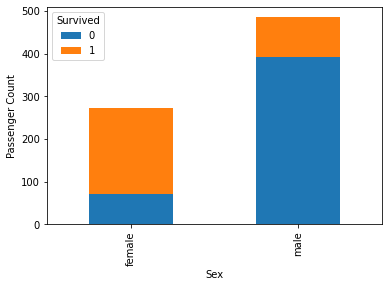

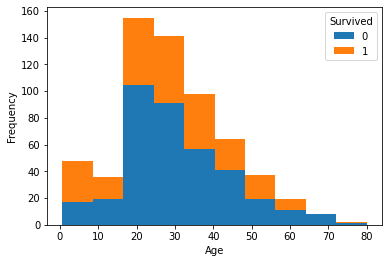

In [1153]:
plt1 = survived_by_sex.plot(kind='bar',stacked=True).set_ylabel('Passenger Count');
plt2 = survived_by_age_df.plot(kind = 'hist', stacked=True).set_xlabel('Age')

SQL manipulation

In [1154]:
survived = np.asarray(query("Titanic.db", "SELECT COUNT(Survived) from Train_DB WHERE Survived=1 GROUP BY Sex ")).flatten()
not_survived = np.asarray(query("Titanic.db", "SELECT COUNT(Survived) FROM Train_DB WHERE Survived = 0 GROUP BY Sex ")).flatten()
print(survived) #(female,male)

[190  91]


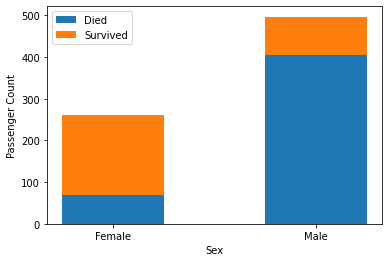

In [1155]:
plt1 = plt.bar([1,2], not_survived, width = 0.5 );
plt2 = plt.bar([1,2], survived, bottom = not_survived, width = 0.5);
plt.xticks([1,2], labels = ["Female", "Male"]);
plt.legend((plt1[0], plt2[0]), ('Died', 'Survived'));
plt.xlabel("Sex");
plt.ylabel("Passenger Count");
plt.show()

In [1156]:
survived = np.asarray(query("Titanic.db", "SELECT Age from Train_DB WHERE Survived=1 AND Age != 'None'")).flatten()
not_survived = np.asarray(query("Titanic.db", "SELECT Age from Train_DB WHERE Survived=0 AND Age != 'None'")).flatten()

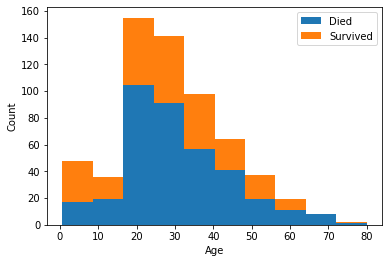

In [1157]:
plt1 = plt.hist([not_survived,survived],10,density= False, histtype='bar', stacked= True)
plt.legend( ('Died', 'Survived'));
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#Pandas Feature Engineering




In [1158]:
train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            149
Ticket           0
Fare             0
Cabin          578
Embarked         2
Family Size      0
dtype: int64

In [1159]:
#fill unknown age with mean
train.Age.fillna((train.Age.mean()),inplace = True)
val.Age.fillna((val.Age.mean()),inplace = True)

In [1160]:
#fill unkown age with "Unknown" 
#keep first letter of cabin as cabin section
def firstletter(str):
    #replaces NaN values with string "Unknown"
    #otherwise return the first letter of the string
    if pd.isna(str):
        return "Unknown"
    else:
        return str[0]

train['Cabin']=train['Cabin'].apply(firstletter)
val['Cabin']=val['Cabin'].apply(firstletter)

In [1161]:
train.Embarked.fillna((train.Embarked.mode()[0]),inplace = True)
val.Embarked.fillna((val.Embarked.mode()[0]),inplace = True)

In [1162]:
train.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Family Size    0
dtype: int64

#SQL Database feature engineering

In [1163]:
train_average_age = query("Titanic.db","SELECT AVG(Age) FROM Train_db")[0][0]
val_average_age = query("Titanic.db","SELECT AVG(Age) FROM Val_db")[0][0]

In [1164]:
#Update values of NONE with the average age in the Age column
connection = sql.connect("Titanic.db")
connection.cursor().execute("UPDATE Train_db SET Age = (?) WHERE Age IS NULL", (train_average_age,))
connection.commit()
connection.close()

connection = sql.connect("Titanic.db")
connection.cursor().execute("UPDATE Val_db SET Age = (?) WHERE Age IS NULL", (val_average_age,))
connection.commit()
connection.close()

In [1165]:
query("Titanic.db", "SELECT AGE from Train_db where Age IS NULL") #No more null

[]

Merge SibSP and Parch into Familty_size

In [1166]:
sumgroup = query("Titanic.db", "SELECT Parch + SibSp + 1,Passengerid FROM Train_db")
query("Titanic.db", "ALTER TABLE TRAIN_db ADD FamilySize int ")
#sqlite3 doesnt support ALTER TABLE DROP so we'll just keep sibsp and parch
connection = sql.connect("Titanic.db")
connection.executemany("UPDATE Train_db SET FamilySize = (?) WHERE PassengerId = (?)", sumgroup) #To update the entire column, we need to index by unique row labels PassengerId (or Index) and call execute many
connection.commit()
connection.close()

In [1167]:
sumgroupval = query("Titanic.db", "SELECT Parch + SibSp + 1,Passengerid FROM Val_db")
query("Titanic.db", "ALTER TABLE Val_db ADD FamilySize int ")
#sqlite3 doesnt support ALTER TABLE DROP so we'll just keep sibsp and parch
connection = sql.connect("Titanic.db")
connection.executemany("UPDATE Val_db SET FamilySize = (?) WHERE PassengerId = (?)", sumgroupval) #To update the entire column, we need to index by unique row labels PassengerId (or Index) and call execute many
connection.commit()
connection.close()

Fill Null in embarked with the mode

In [1168]:
train_embarked_mode = query("Titanic.db","SELECT Embarked FROM Train_db GROUP BY [Embarked] ORDER BY COUNT(*) DESC")[0] #Sort by most common, take first
val_embarked_mode=query("Titanic.db","SELECT Embarked FROM Val_db GROUP BY [Embarked] ORDER BY COUNT(*) DESC")[0]

In [1169]:
connection = sql.connect("Titanic.db")

connection.cursor().execute("UPDATE Train_db SET Embarked = (?) WHERE Embarked IS NULL", train_embarked_mode)

connection.cursor().execute("UPDATE Val_db SET Embarked = (?) WHERE Embarked IS NULL", val_embarked_mode)

connection.commit()
connection.close()

Replace Cabin with first Letter of Cabin(Cabin Section) or "Unknown"

In [1170]:
connection = sql.connect("Titanic.db")
connection.execute("UPDATE Train_db SET Cabin = SUBSTR(Cabin, 1, 1)")
connection.execute("UPDATE Val_db SET Cabin = SUBSTR(Cabin, 1, 1)")
connection.commit()
connection.close()

#Classification

In [1171]:
from sklearn.ensemble import RandomForestClassifier

In [1172]:
train.pop('Ticket');
train.pop('PassengerId');
train.pop('Name');

In [1173]:
val.pop('Ticket');
val.pop('PassengerId');
val.pop('Name');

In [1174]:
def obj_to_int(df,col):
  df[col] = df[col].astype("category")
  df[col] = df[col].cat.codes

In [1175]:
obj_to_int(val,"Sex")
obj_to_int(val,"Cabin")
obj_to_int(val,"Embarked")
obj_to_int(train,"Sex")
obj_to_int(train,"Cabin")
obj_to_int(train,"Embarked")

In [1176]:
classifier = rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=300,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto')
classifier.fit(train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1177]:
predictions = classifier.predict(val)
accuracy = (y_val == predictions).sum()/len(predictions)
print("Accuracy of {}%".format(int(100*accuracy)))

Accuracy of 81%


In [1178]:
test_df = pd.read_csv(test_path)
test_connect = sql.connect("Titanic_test.db")
test_df.to_sql("Test_db",test_connect)

In [1179]:


test_df.Age.fillna((test_df.Age.mean()),inplace = True)
test_df.Embarked.fillna((test_df.Embarked.mode()[0]),inplace = True)
test_df['Cabin']=test_df['Cabin'].apply(firstletter)
test_df = add_groupsize(test_df);
test_df.pop('Ticket');
test_df.pop('PassengerId');
test_df.pop('Name');
test_df.pop("Survived");
obj_to_int(test_df,"Sex");
obj_to_int(test_df,"Cabin");
obj_to_int(test_df,"Embarked");

In [1180]:
predictions_test = classifier.predict(test_df)

In [1181]:
ids = query("Titanic_test.db", "SELECT PassengerID from Test_db")

In [1182]:
prediction_col = [(int(predictions_test[i]),ids[i][0]) for i in range(len(ids))]

In [1184]:
connection = sql.connect("Titanic_test.db")
connection.cursor().execute("ALTER TABLE Test_db ADD Predictions int")
connection.cursor().executemany("UPDATE Test_db SET Predictions = (?) WHERE PassengerId = (?)",prediction_col)
connection.commit()
connection.close()

In [1192]:
query("Titanic_test.db", "SELECT COUNT(*) FROM test_db GROUP BY Predictions ")

[(598,), (293,)]